In [1]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from functions import *

In [2]:
'''Import Data Links'''
import_path = "./Cleaned Data/"
import_path_raw = "./Raw Data/"
fig_savepath = '../Figures/canopyInteractionFigs/'

In [3]:
'''Colors'''
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

In [4]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv(import_path + 'VegData_LAI_Snow.csv')

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "/ATM/WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

In [5]:
'''Organize all data into one data frame'''
#Remove rows on allSnow containing NaNs (these are grid locations where data was not taken)
allSnow_nan = allSnow_df.dropna(how = 'any')

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

#Take average snow depth per site
avgSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed'])['depths'].mean().reset_index()
avgSnow = avgSnow.rename(columns = {'depths' : 'meanDepth'})

#Add in other columns aggregated by year, joined on stakes
## LAI
lai_sub = lai_df[['Stake_ID', 'OLS Prediction Ring 5']]
peakData = pd.merge(peakSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

avgData = pd.merge(avgSnow, lai_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'OLS Prediction Ring 5' : 'lai5ring'})

## Veg Survey
veg_sub = forestInv[['Stake_ID', 'DIST_M', 'DBH_CM', 'n', 'basalArea_m2', 'Co', 'Dom', 'Int', 'Sup', 'prop_Coniferous']]
peakData = pd.merge(peakData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
peakData = peakData.drop(columns = 'Stake_ID')
peakData = peakData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_m',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

avgData = pd.merge(avgData, veg_sub, left_on = 'stakes', right_on = 'Stake_ID')
avgData = avgData.drop(columns = 'Stake_ID')
avgData = avgData.rename(columns = {'DIST_M' : 'avgDist_m',
                                    'DBH_CM' : 'avgDBH_m',
                                    'n' : 'nTrees',
                                    'Co' : 'nCo',
                                    'Dom' : 'nDom',
                                    'Int' : 'nInt',
                                    'Sup' : 'nSup',
                                    'prop_Coniferous' : 'pCon'})

In [6]:
'''Set PCA Data'''
#Switch this depending on average/maximum snow depth considerations
pca_data = peakData

#remove strings
pca_data_forplot = pca_data.drop(columns = ['stakes', 'zones', 'watershed'])

#remove depths 
pca_data = pca_data_forplot.drop(columns = 'maxDepth')

In [31]:
pca_data.head()

,northing,easting,aspect,slope,lai5ring,avgDist_m,avgDBH_m,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,464819.0,5262240.0,193.3626,6.632267,0.380709,5.354320,20.983333,12,4.651855,7,2,3,0,0.000000
1,464819.0,5262292.0,115.0966,3.120716,0.403804,4.480560,24.216667,18,10.077594,9,3,6,0,0.111111
2,464819.0,5262396.0,135.0012,7.452870,1.373774,5.025390,14.543750,16,2.845013,11,3,2,0,0.437500
3,464819.0,5262448.0,254.4066,9.503919,1.750984,5.486400,19.135000,20,6.132624,16,0,4,0,0.650000
4,464819.0,5262500.0,355.2919,3.051387,0.778448,5.614851,23.850000,14,8.338256,3,4,4,3,0.142857


Principle Component Analysis

In [7]:
'''Principle Component Analysis to Determine Snow Controls'''
#Standardize Data
scaler = StandardScaler()
scaler.fit(pca_data)
pca_data_scaled = scaler.transform(pca_data)
#Convert back to dataframe
pca_scaled = pd.DataFrame(data = pca_data_scaled, 
                            columns = pca_data.columns)


In [8]:
pca_scaled.head()

,northing,easting,aspect,slope,lai5ring,avgDist_m,avgDBH_m,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon
0,1.849643,-1.201287,0.147365,0.326056,-1.005747,0.460653,0.462296,-0.595224,-0.223636,-0.549850,0.080437,-0.132527,-0.573105,-1.380173
1,1.849643,-1.020997,-0.635011,-0.273271,-0.970471,-1.198747,1.225059,0.161417,1.741685,-0.218615,0.415593,0.814095,-0.573105,-1.082135
2,1.849643,-0.660417,-0.436038,0.466111,0.511104,-0.164034,-1.056841,-0.090797,-0.878113,0.112620,0.415593,-0.448068,-0.573105,-0.206649
3,1.849643,-0.480126,0.757584,0.816170,1.087272,0.711492,0.026263,0.413630,0.312731,0.940707,-0.589874,0.183014,-0.573105,0.363348
4,1.849643,-0.299836,1.766071,-0.285104,-0.398222,0.955440,1.138560,-0.343010,1.111659,-1.212319,0.750748,0.183014,0.836169,-0.996982


In [9]:
#Run PCA
pca = PCA(n_components = 10) #adjustable
pca.fit_transform(pca_data_scaled)

#Extract variance values
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

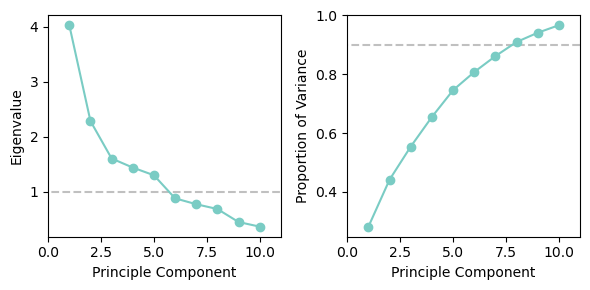

In [27]:
#Scree Plot
PCnumbers = np.arange(pca.n_components_) + 1

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (6, 3), 
                              sharex = True, 
                              tight_layout = True)

ax.plot(PCnumbers, 
         eigenvalues, 
         'o-',
         color = pal[2])
ax.hlines(1, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('Principle Component')

ax2.plot(PCnumbers, 
         np.cumsum(prop_var), 
         'o-', 
         color = pal[2])
ax2.hlines(0.90, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)

ax2.set_ylabel('Proportion of Variance')
ax2.set_xlabel('Principle Component')

ax.set_xlim(0, 11)
plt.savefig(fig_savepath + 'PCAeigenvalues.pdf', bbox_inches = 'tight')
plt.show()
#Using Kaiser's rule we keep all principle components with eigenvalues above 1 and rerun (here 5)

In [19]:
#Rerun PCA
pca2 = PCA(n_components = 5) #adjustable
pc = pca2.fit_transform(pca_data_scaled)

pca_snow = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_snow.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.989419,1.303565,1.451796,0.061740,-0.160048
1,-1.035720,1.878999,1.259414,0.445507,-0.707266
2,-0.909351,-0.932190,1.185188,-0.919091,0.074024
3,0.715046,-0.156907,1.404941,-0.358918,-1.516198
4,-0.945851,1.612351,1.405515,2.516300,-0.765118


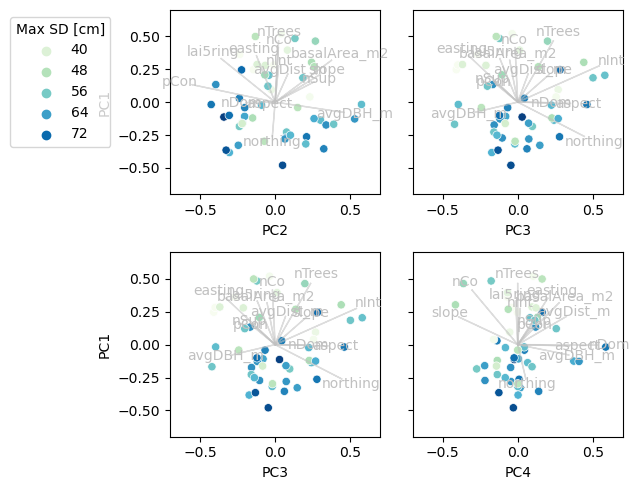

In [134]:
'''BiPlot'''
def biplot(ax, data, score, coef, ipca1, ipca2, labels=None, leg=None):
 
    xs = score[:, ipca1]
    ys = score[:, ipca2]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    sns.scatterplot(x = xs * scalex, y = ys * scaley, 
                hue = data.maxDepth, 
                ax = ax,
                palette = 'GnBu',
                legend = leg)
 
    for i in range(n):
        ax.arrow(0, 0, coef[i, ipca1], 
                  coef[i, ipca2], color = 'silver',
                  alpha = 0.5)
        ax.text(coef[i, ipca1]* 1.15, 
                 coef[i, ipca2] * 1.15, 
                 labels[i], 
                 color = 'silver', 
                 ha = 'center', 
                 va = 'center')
 
    ax.set_xlabel("PC{}".format(ipca1 + 1))
    ax.set_ylabel("PC{}".format(ipca2 + 1)) 

    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)

    #plt.title('Biplot of PCA')   

    #plt.show()

 
fig, axs = plt.subplots(2, 2, figsize = (6.5,5), 
                        tight_layout = True, 
                        sharey = True)
for i in range(0, 2):
    for j in range(0, 2):
        if((i == 0) & (j == 0)):
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns), True)
        else:
            biplot(axs[i, j], pca_data_forplot, pc, np.transpose(pca.components_), i+j+1, 0, list(pca_data.columns))

axs[0, 0].legend(title = 'Max SD [cm]', bbox_to_anchor = (-0.25, 1))
plt.savefig(fig_savepath + 'PCAplots.pdf', bbox_inches = 'tight')
plt.show()

Variable Importance Analysis

In [21]:
#Sort out PCA coefficients
pca_coefs = pd.DataFrame(data = abs(np.transpose(pca2.components_)), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = pca_data.columns)
pca_coefs.head()

,PC1,PC2,PC3,PC4,PC5
northing,0.260310,0.018329,0.442585,0.053849,0.280972
easting,0.352037,0.123918,0.325950,0.200142,0.069656
aspect,0.009957,0.032736,0.350417,0.344398,0.526725
slope,0.209194,0.298506,0.208729,0.391048,0.219950
lai5ring,0.330318,0.358936,0.118782,0.013367,0.255389


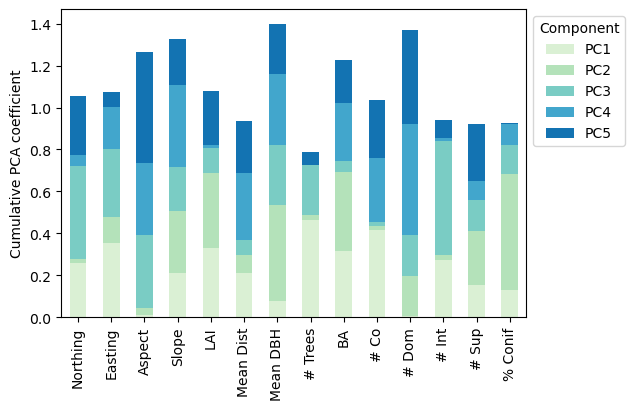

In [22]:
#Variable Importance Plots
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'LAI', 'Mean Dist', 'Mean DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient')
plt.savefig(fig_savepath + 'PCAcoef.pdf', bbox_inches = 'tight')
plt.show()

In [23]:
#Version weighted by PCA explained percentage
pca_coefs_weighted = pca_coefs
for i in range(0, 5):
    pca_coefs_weighted.iloc[:, i] = pca_coefs_weighted.iloc[:, i]*prop_var[i]

pca_coefs_weighted.head()

,PC1,PC2,PC3,PC4,PC5
northing,0.073392,0.002932,0.049713,0.005427,0.025569
easting,0.099254,0.019822,0.036612,0.020172,0.006339
aspect,0.002807,0.005237,0.039360,0.034711,0.047932
slope,0.058980,0.047750,0.023445,0.039413,0.020016
lai5ring,0.093131,0.057416,0.013342,0.001347,0.023241


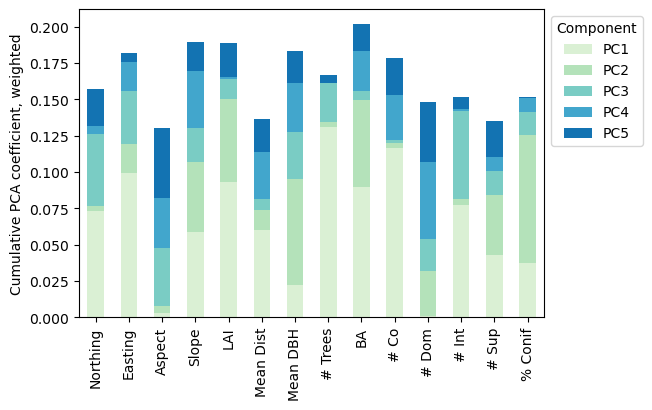

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

pca_coefs_weighted.plot(kind = 'bar', stacked = True, ax = ax, color = pal)

ax.set_xticklabels(['Northing', 'Easting', 'Aspect', 'Slope', 'LAI', 'Mean Dist', 'Mean DBH', '# Trees', 'BA', '# Co', '# Dom', '# Int', '# Sup', '% Conif'])
ax.legend(title = 'Component', bbox_to_anchor = (1,1))
ax.set_ylabel('Cumulative PCA coefficient, weighted')
plt.savefig(fig_savepath + 'PCAcoef-weighted.pdf', bbox_inches = 'tight')
plt.show()

Random Forest Variable Importance

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

In [36]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(pca_data, pca_data_forplot.maxDepth, test_size = 0.5, random_state = 48492)

#Fit random forest regression with 100 trees
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestRegressor()

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


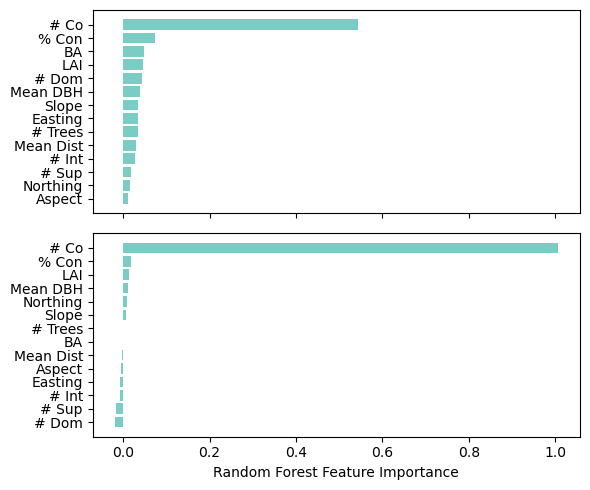

In [135]:
#Sort and plot feature importance
sorted_idx = rf.feature_importances_.argsort()

fig, [ax, ax2] = plt.subplots(2, 1, figsize = (6, 5), 
                              sharex = True, 
                              tight_layout = True)

#Without permutation
ax.barh(pca_data.columns[sorted_idx], rf.feature_importances_[sorted_idx], 
        color = pal[2])
ax.set_yticklabels(['Aspect', 'Northing', '# Sup', '# Int', 'Mean Dist', '# Trees', 'Easting', 'Slope', 'Mean DBH', '# Dom', 'LAI', 'BA', '% Con', '# Co'])

#With permutation
perm_importance = permutation_importance(rf, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
ax2.barh(pca_data.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], 
         color = pal[2])
ax2.set_yticklabels(['# Dom', '# Sup', '# Int', 'Easting', 'Aspect', 'Mean Dist', 'BA', '# Trees', 'Slope', 'Northing', 'Mean DBH', 'LAI', '% Con', '# Co'])

ax2.set_xlabel("Random Forest Feature Importance")

plt.savefig(fig_savepath + 'randomForest-importance.pdf', bbox_inches = 'tight')
plt.show()

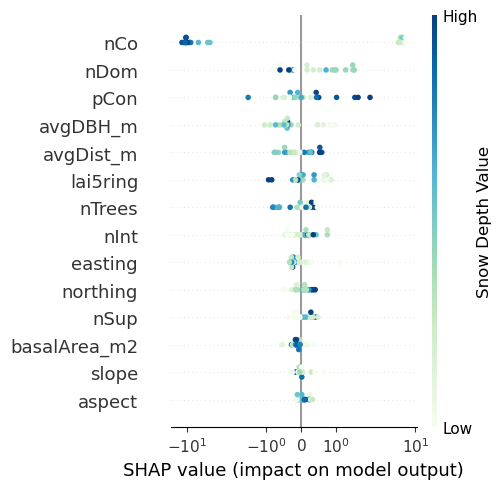

In [78]:
#SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test,
                cmap = 'GnBu', 
                plot_size = (5, 5), 
                color_bar_label = 'Snow Depth Value', 
                use_log_scale = True, 
                show = False)

plt.savefig(fig_savepath + 'randomForest-SHAP.pdf', bbox_inches = 'tight')

Canopy Height Diversity

In [121]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import log10, floor, pow

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)


#Shannon Diversity Index for Canopy Class
def calcH(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc index masking any zeroes
    H = np.sum(pCo*np.log(pCo, where = (pCo != 0)) + 
               pDom*np.log(pDom, where = (pDom != 0)) +
               pInt*np.log(pInt, where = (pInt != 0)) + 
               pSup*np.log(pSup, where = (pSup != 0)))

    return -H

#Hill-Simpson Diversity Index for Canopy Class
def calcS(co, dom, int, sup):
    tot = np.sum(co + dom + int + sup)

    #calc proportions
    pCo = co/tot
    pDom = dom/tot
    pInt = int/tot
    pSup = sup/tot

    #calc index masking any zeroes
    S = np.sum(pow(pCo, 2) + pow(pDom, 2) + pow(pInt, 2) + pow(pSup, 2))

    return 1/S

dd = pca_data_forplot
dd['H'] = [calcH(dd.nCo[i], dd.nDom[i], dd.nInt[i], dd.nSup[i]) for i in dd.index]
dd['S'] = [calcS(dd.nCo[i], dd.nDom[i], dd.nInt[i], dd.nSup[i]) for i in dd.index]

In [122]:
dd.head()

,northing,easting,aspect,slope,maxDepth,lai5ring,avgDist_m,avgDBH_m,nTrees,basalArea_m2,nCo,nDom,nInt,nSup,pCon,H,S
0,464819.0,5262240.0,193.3626,6.632267,70.0,0.380709,5.354320,20.983333,12,4.651855,7,2,3,0,0.000000,0.959615,2.322581
1,464819.0,5262292.0,115.0966,3.120716,59.0,0.403804,4.480560,24.216667,18,10.077594,9,3,6,0,0.111111,1.011404,2.571429
2,464819.0,5262396.0,135.0012,7.452870,49.0,1.373774,5.025390,14.543750,16,2.845013,11,3,2,0,0.437500,0.831403,1.910448
3,464819.0,5262448.0,254.4066,9.503919,36.0,1.750984,5.486400,19.135000,20,6.132624,16,0,4,0,0.650000,0.500402,1.470588
4,464819.0,5262500.0,355.2919,3.051387,62.0,0.778448,5.614851,23.850000,14,8.338256,3,4,4,3,0.142857,1.376055,3.920000


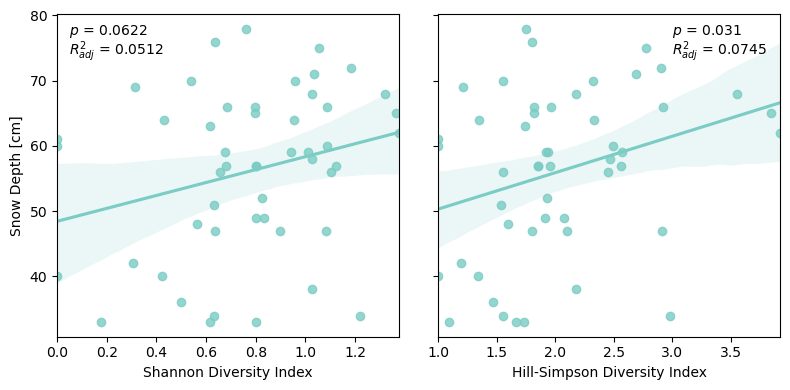

In [129]:
fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 4), 
                              sharey = True, 
                              tight_layout = True)

sns.regplot(x = dd.H, y = dd.maxDepth, ax = ax, color = pal[2])

#Do regression and add to plot
results = smf.ols('maxDepth ~ H', data = dd).fit()
ax.text(0.05, 77, r'$ p $ = ' + str(round_sig(results.pvalues.H, 3)))
ax.text(0.05, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results.rsquared_adj, 3)))

ax.set_xlabel('Shannon Diversity Index')
ax.set_ylabel('Snow Depth [cm]')
ax.set_xlim(min(dd.H), max(dd.H))

sns.regplot(x = dd.S, y = dd.maxDepth, ax = ax2, color = pal[2])

#Do regression and add to plot
results2 = smf.ols('maxDepth ~ S', data = dd).fit()
ax2.text(3, 77, r'$ p $ = ' + str(round_sig(results2.pvalues.S, 3)))
ax2.text(3, 74, r'$ R_{adj}^2 $ = ' + str(round_sig(results2.rsquared_adj, 3)))

ax2.set_xlabel('Hill-Simpson Diversity Index')
ax2.set_ylabel(' ')
ax2.set_xlim(min(dd.S), max(dd.S))

plt.savefig(fig_savepath + 'DiversityIndex-SnowDepth.pdf', bbox_inches = 'tight')